In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split


from category_encoders import MEstimateEncoder

from sklearn.metrics import mean_squared_error



from sklearn.ensemble import HistGradientBoostingRegressor

import math
import seaborn as sns
import re


In [80]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [19]:
train.columns

Index(['Accident_ID', 'Police_Force', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'state', 'postcode', 'country'],
      dtype='object')

In [11]:
cat_cols = [#'Pedestrian_Crossing-Physical_Facilities', 
            #'Pedestrian_Crossing-Human_Control',
            #'2nd_Road_Class',     
            'Police_Force',
            'Local_Authority_(District)',
            
            '1st_Road_Class', 
            '2nd_Road_Class',
            '2nd_Road_Number',
            'Did_Police_Officer_Attend_Scene_of_Accident',            
            #'Weather_Conditions',
            '1st_Road_Number',
            #'Road_Type',
            #'Light_Conditions',
            'Number_of_Vehicles', 
            'Urban_or_Rural_Area', 
            #'Special_Conditions_at_Site',                      
            #'state',
            'Day_of_Week', 
            'Speed_limit',
            #'Time_split',            
            #'Month', 
            'Time_cos',
            'Time_sin',
            'Month_cos',
            'Month_sin'    
            
           ]
           

In [63]:
def features(df):
    
    
    ## create date features
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].apply(lambda x : x.month)
    df['year'] = df['Date'].apply(lambda x : x.year)
    df['day'] = df['Date'].apply(lambda x: x.day)
    
    
    
    
    # take the hour of time
    df['Time'].fillna(2, inplace=True)
    
    df['Time_hour'] = df['Time'].apply(lambda x : int(str(x).split(':')[0]))
    df['Time_split'] = df['Time'].apply(lambda x : int(str(x).split(':')[0])* 60 + int(str(x).split(':')[-1]))
    
    df["Time_norm"] = 2 * math.pi * df["Time_split"] / df["Time_split"].max()
    
    df["Time_cos"] = np.cos(df["Time_norm"])
    
    df["Time_sin"] = np.sin(df["Time_norm"])
    
    
    df['Month_norm'] = 2 * math.pi * df["Month"] / df["Month"].max()
    
    
    df['Month_cos'] = np.cos(df['Month_norm'])
    
    df['Month_sin'] = np.sin(df['Month_norm'])
    
    
    
    df['daylight'] = df['Time_split'].apply(lambda x : 1 if ((x>7) & (x<16)) else 0)
    
    df['winter'] = df['Month'].apply(lambda x: 1 if ((x == 11) or (x == 12) or (x == 1) or (x == 2) or (x==3)) else 0)
    
    #do one hot encoding for related features
    df_cat = pd.get_dummies(df[cat_cols])
    
    #df_cat = df[te_cols]
    df_cat['Number_of_Casualties'] = df['Number_of_Casualties']
    #df_cat['Local_Authority_(Highway)'] = df['Local_Authority_(Highway)']
    df_cat['postcode'] = df['postcode']
    df_cat['Road_Type'] = df['Road_Type']
    #df_cat['postcode_district'] = df['postcode'].apply(lambda x: x.split(' ')[0] + ' ')
    
    #df_cat['postcode_sector'] = df['postcode'].apply(lambda x: x.split(' ')[0] + ' ' +x.split(' ')[-1][0])
    #df_cat['Light_Conditions'] = df['Light_Conditions']
    #df_cat['Pedestrian_Crossing-Physical_Facilities'] = df['Pedestrian_Crossing-Physical_Facilities']
    
    
    return df_cat

In [81]:
x_train = features(train)
x_test = features(test)

In [41]:
arr = train['Time_hour']

C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2417643263.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


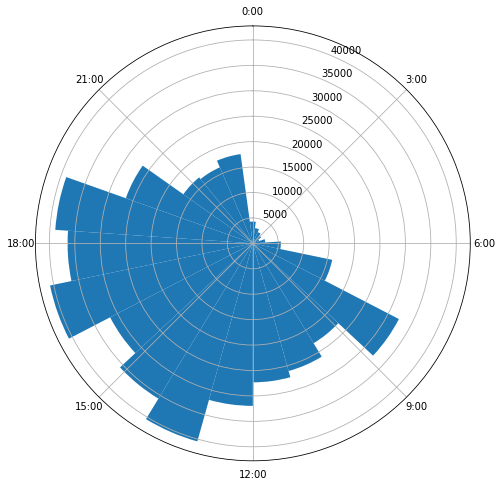

In [42]:

N = 23
bottom = 2

# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii, tick = np.histogram(arr, bins = 23)

# width of each bin on the plot
width = (2*np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the top
ax.set_theta_zero_location("N")
# clockwise
ax.set_theta_direction(-1)

# set the label
ticks = ['0:00', '3:00', '6:00', '9:00', '12:00','15:00','18:00','21:00']
#ticks = ['0','1','2','3','4','5','6','7','8','9','10','11','12']
ax.set_xticklabels(ticks)

plt.show()


We can check from time feature that peak hours are between 08 to 09 hours and 17 to 18 hrs

In [88]:
def train_and_evaluate(train, test, params, _eval):
    
    
    
    
    
    
    # Split features and target
    x = train.drop(['Number_of_Casualties','postcode'], axis = 1)
    y = train['Number_of_Casualties']
    x_test = test.drop(['Number_of_Casualties','postcode'],axis=1)
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state=42, shuffle=True)
    
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
        _cols = ['1st_Road_Number','2nd_Road_Number','Local_Authority_(District)'
                 ,'Road_Type']
        
        
        
        for col in _cols:
            encoder = MEstimateEncoder(m=1000)
            encoder.fit(x_train[col], y_train)
            x_train[col] = encoder.transform(x_train[col])
            x_val[col] = encoder.transform(x_val[col])
            x_test[col] = encoder.transform(x_test[col])
        
        
       
        
        
        
        
        
        model = HistGradientBoostingRegressor(**params)
        
        
        
        
        model.fit(x_train, y_train)
        
        
        
        val = model.predict(x_val)
        
        
        print(f' current fold rmse is {mean_squared_error(y_val,val, squared=False)}')
        
        
        
        
        oof_predictions[val_ind] =  val
        
        
        # Predict the test set
        
        pred = model.predict(x_test)
        
        
        
        
        
        test_predictions += pred
        
        
        
    
    mean_score = mean_squared_error(y, oof_predictions, squared=False)
    
    
        
    
    print(f'Our out of folds mean score is {mean_score}')
    
    
    if _eval:
        return mean_score
    else:
        return [x/5 for x in test_predictions]

In [89]:
best_params_random = {
    'min_samples_leaf': 30,
  'max_leaf_nodes': 3,
  'max_iter': 420,
  'max_depth': 4,
  'learning_rate': 0.1,
  'l2_regularization': 0.2,
    'random_state':42,
    
}

In [90]:
test_predictions = train_and_evaluate(x_train, x_test, best_params_random, False)

Training fold 1


C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = encoder.transform(x_train[col])
C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = encoder.transform(x_val[col])


 current fold rmse is 0.8119001909158898
Training fold 2


C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = encoder.transform(x_train[col])
C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = encoder.transform(x_val[col])


 current fold rmse is 0.8098117408739018
Training fold 3


C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = encoder.transform(x_train[col])
C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = encoder.transform(x_val[col])


 current fold rmse is 0.807168143255788
Training fold 4


C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = encoder.transform(x_train[col])
C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = encoder.transform(x_val[col])


 current fold rmse is 0.8103909911594669
Training fold 5


C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = encoder.transform(x_train[col])
C:\Users\VARUN\AppData\Local\Temp/ipykernel_10112/2665559026.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[col] = encoder.transform(x_val[col])


 current fold rmse is 0.8094338020056736
Our out of folds mean score is 0.809742435849848


In [91]:
x_test['Number_of_Casualties'] = test_predictions

In [92]:
_aggs = {
          'Number_of_Casualties': [ np.mean],
          
        }

In [93]:
#x_train['postcode'] = train['postcode']
#x_test['postcode'] = test['postcode']

In [94]:
train_df = x_train.groupby(['postcode']).agg(_aggs).reset_index()

In [95]:
test_df = x_test.groupby(['postcode']).agg(_aggs).reset_index()

In [96]:
test_df.columns = ['postcode','Number_of_Casualties']

In [97]:
test_df

,postcode,Number_of_Casualties
0,AB10 1AU,1.431995
1,AB10 1PG,1.366499
2,AB10 1TT,1.537938
3,AB10 1YP,1.442171
4,AB10 6LQ,1.385022
...,...,...
49767,ZE2 9LZ,1.325967
49768,ZE2 9RE,1.356500
49769,ZE2 9RJ,1.272555
49770,ZE2 9SB,1.573937


In [98]:
submission_df = test_df[['postcode','Number_of_Casualties']]

In [99]:
submission_df.columns = ['postcode','Accident_risk_index']

In [100]:
submission_df.to_csv('my_submission_v23.csv', index=False)

In [101]:
submission_df.shape

(49772, 2)